In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import datetime

# Plot parameters
rcParams['axes.labelsize'] = 24
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'k'
rcParams['figure.figsize']=10,10


               DELIVERED_VOLUME  Facility_A  Facility_B  Facility_C  \
DELIVERY_DATE                                                         
2019-03-13                  0.0         0.0         0.0         0.0   
2019-03-14                  0.0         0.0         0.0         0.0   
2019-03-15                  0.0         0.0         1.0         0.0   
2019-03-18                  0.0         0.0         0.0         0.0   
2019-03-19                  0.0        13.0         0.0         0.0   
...                         ...         ...         ...         ...   
2019-05-29               1398.0       284.0        36.0       206.0   
2019-05-30                628.0       264.0        21.0       179.0   
2019-05-31                992.0       208.0        52.0       163.0   
2019-06-01                  0.0         0.0         0.0         0.0   
2019-06-02                  0.0         0.0         0.0         0.0   

               Facility_D  Facility_E  Facility_F  Facility_G  Facility_H  \

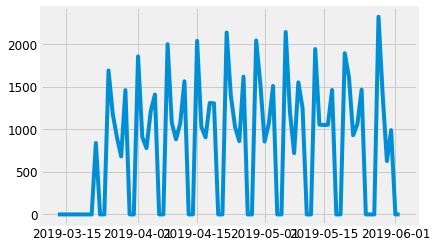

In [15]:
# Data input and handling missing values
Delivery = pd.read_csv('Delivery_Volume.csv', index_col=['DELIVERY_DATE'], parse_dates=['DELIVERY_DATE'])
Delivery.sort_index(inplace=True)
Delivery=Delivery.fillna(0)
#Delivery['Week']=Delivery.index.dayofweek()
print(Delivery)
print(Delivery.index.min(), Delivery.index.max())
# plot data to visualize trends, stationarity, seasonality
plt.plot(Delivery.index, Delivery.DELIVERED_VOLUME)
plt.show()

In [3]:
# Create testing data from training data
y = Delivery["DELIVERED_VOLUME"].resample("1D").mean()
y = y.fillna(0)
print(y)

DELIVERY_DATE
2019-03-13       0.0
2019-03-14       0.0
2019-03-15       0.0
2019-03-16       0.0
2019-03-17       0.0
               ...  
2019-05-29    1398.0
2019-05-30     628.0
2019-05-31     992.0
2019-06-01       0.0
2019-06-02       0.0
Freq: D, Name: DELIVERED_VOLUME, Length: 82, dtype: float64


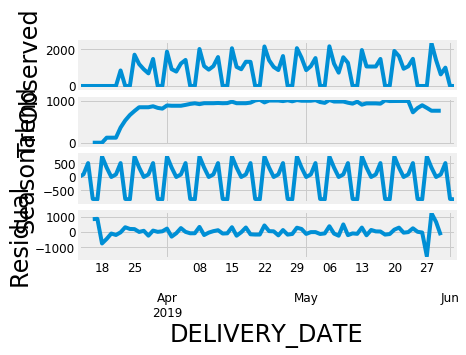

In [4]:
# using decomposition to handle trends and seasonality
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2156      0.180     -1.198      0.231      -0.568       0.137
ma.L2         -0.8530      0.127     -6.741      0.000      -1.101      -0.605
ma.L3         -0.4261      0.228     -1.869      0.062      -0.873       0.021
ma.L4          0.8637      0.216      3.994      0.000       0.440       1.287
ar.S.L12      -0.2008      0.059     -3.404      0.001      -0.316      -0.085
sigma2       4.48e+05   1.24e-06    3.6e+11      0.000    4.48e+05    4.48e+05


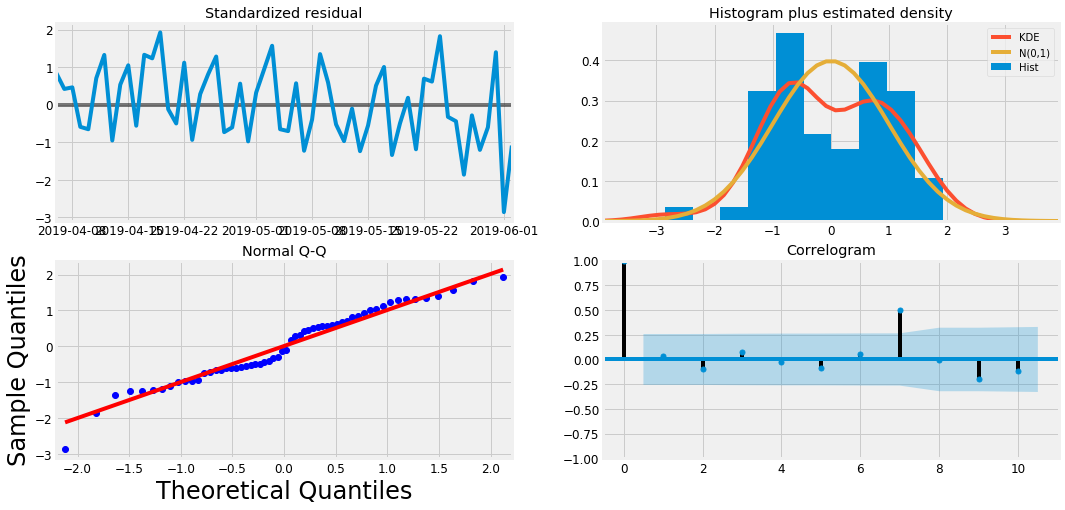

In [5]:
# Final prediction modelling
mod = sm.tsa.statespace.SARIMAX(y, order = (0, 0, 4), seasonal_order = (1, 1, 0, 12), enforce_stationarity = False, enforce_invertibility = False)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize = (16, 8))
plt.show()

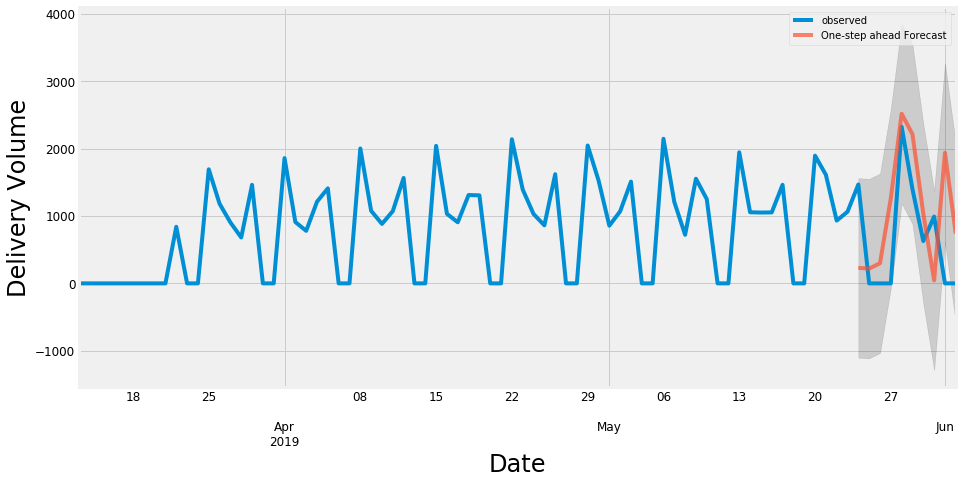

The MSE of SARIMA Forecast is 934823.27
The RMSE of SARIMA Forecast is 966.86


In [9]:
pred = results.get_prediction(start = pd.to_datetime(y.index[-10]), dynamic = False)
pred_ci = pred.conf_int()
ax = y['2019':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label='One-step ahead Forecast', alpha = 0.7, figsize = (14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = 0.15)
ax.set_xlabel('Date')
ax.set_ylabel('Delivery Volume')
plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
y_truth = y['2019-05-24': ]
y_diff = y_truth - y_forecasted

#print(y_truth)
#print(y_forecasted)
y_diff_values = []
y_diff_values_squared = []
for x in y_diff.index:
    y_diff_values.append(y_diff[x])

for i in y_diff_values:
    y_diff_values_squared.append(i*i)

mse = np.mean(y_diff_values_squared)
print("The MSE of SARIMA Forecast is {}".format(round(mse, 2)))
print('The RMSE of SARIMA Forecast is {}'.format(round(np.sqrt(mse), 2)))

2019-06-03    2088.952425
2019-06-04    3036.613957
2019-06-05    -162.125955
2019-06-06    -229.725871
2019-06-07     212.051554
Freq: D, dtype: float64


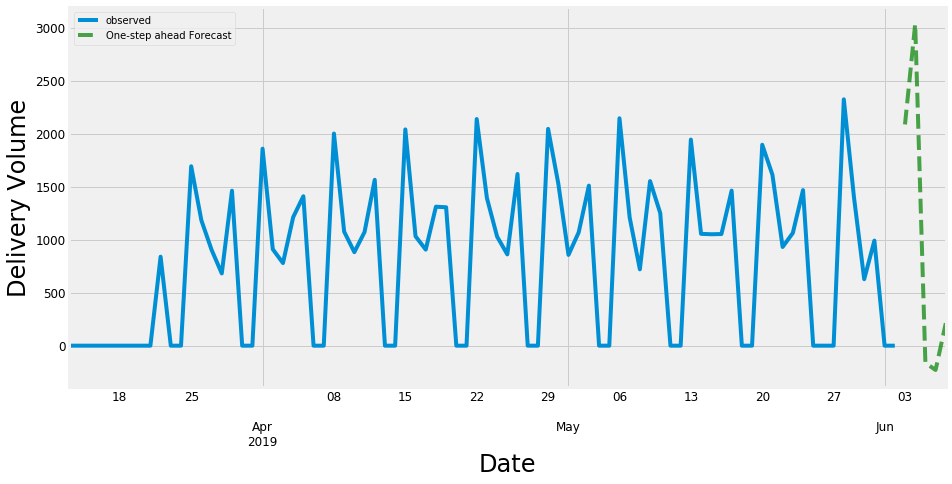

In [7]:
# 5 day prediction using the model
import datetime
y_pred = results.get_prediction(start = datetime.date(2019,6,3), end=datetime.date(2019,6,7), dynamic = False)
print(y_pred.predicted_mean)
#pred_ci = pred.conf_int()
ax = y['2019':].plot(label = 'observed')
y_pred.predicted_mean.plot(ax = ax, label='One-step ahead Forecast', alpha = 0.7,color='g',linestyle='dashed', figsize = (14, 7))

ax.set_xlabel('Date')
ax.set_ylabel('Delivery Volume')
plt.legend()
plt.show()

In [8]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-05-24': ]
y_diff = y_truth - y_forecasted
print(y_truth)
print(y_forecasted)
y_diff_values = []
y_diff_values_squared = []
for x in y_diff.index:
    y_diff_values.append(y_diff[x])

for i in y_diff_values:
    y_diff_values_squared.append(i*i)

mse = np.mean(y_diff_values_squared)
print("The MSE of SARIMA Forecast is {}".format(round(mse, 2)))
print('The RMSE of SARIMA Forecast is {}'.format(round(np.sqrt(mse), 2)))

y_diff_percentage = np.abs(y_diff / y_truth)
print(y_diff_percentage)

DELIVERY_DATE
2019-05-24    1469.0
2019-05-25       0.0
2019-05-26       0.0
2019-05-27       0.0
2019-05-28    2326.0
2019-05-29    1398.0
2019-05-30     628.0
2019-05-31     992.0
2019-06-01       0.0
2019-06-02       0.0
Freq: D, Name: DELIVERED_VOLUME, dtype: float64
DELIVERY_DATE
2019-05-04     447.068882
2019-05-05     480.750795
2019-05-06    1757.277818
2019-05-07    2047.835909
2019-05-08     991.128461
2019-05-09     633.302948
2019-05-10     847.128734
2019-05-11     357.735512
2019-05-12     661.024422
2019-05-13    2017.161005
2019-05-14    1899.181716
2019-05-15    1430.458808
2019-05-16     708.075131
2019-05-17     780.144160
2019-05-18     911.346951
2019-05-19     337.241617
2019-05-20    1771.685514
2019-05-21    2419.513832
2019-05-22     460.163837
2019-05-23     645.436679
2019-05-24     229.830412
2019-05-25     219.768293
2019-05-26     298.923944
2019-05-27    1264.534290
2019-05-28    2519.144807
2019-05-29    2214.494165
2019-05-30    1035.601222
2019-05-31  

Feature #1- weekday coding(Monday-0, Sunday-6)

This feature basically assigned numerical values to the weekdays to see if there is any effect on deliveries based on the weekday. We did not use it since it did not have much relevant significance and the developed supervised learning model(Random Forest) was not as accurate as the current model. 

Feature #2- Lag feature upto previous 15 days(t-1,t-2, t3....t-15)

Upon analysing the relevance while developing Rainforest model for prediction, we found that lag features though relevant were not providing the best model.

## Algorithm Methods:

Model Type #1- Moving averages
We initially modelled using moving averages and various iterations of moving averages but did not achieve best results. 

Model Type #2- Random Forest(Supervised Learning Models)
We generated multiple features such as weekday or lag features and tried to model the time series data as supervised learning model but we still did not achieve the best performance model.

Model Type #3- ARIMA(Autoregressive Integrated Moving Average)
We used ARIMA With various iterations in the parameter but the model did not factor in seasonality of the data.

Model Type #4- SARIMA(Seasonal Autoregressive Integrated Moving Average)
SARIMA provided us with best possible model.



Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting. Although the method can handle data with a trend, it does not support time series with a seasonal component.

An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA.

Seasonal Autoregressive Integrated Moving Average, or SARIMA is a method for time series forecasting with univariate data containing trends and seasonality.